In [1]:
from PIL import Image
import cv2 
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Iterable

def imgshow(img) -> None:
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

In [4]:
%load_ext kedro.extras.extensions.ipython

2022-05-16 19:43:47,581 - root - INFO - Updated path to Kedro project: C:\Users\Lianz\Documents\medgc-tesis
2022-05-16 19:43:48,163 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


d:\Programs\Anaconda3\envs\medgc-tesis-v2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Programs\Anaconda3\envs\medgc-tesis-v2\lib\site-packages\torchvision\transforms\functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
d:\Programs\Anaconda3\envs\medgc-tesis-v2\lib\site-packages\torchvision\transforms\functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
d:\Programs\Anaconda3\envs\medgc-tesis-v2\lib\site-packages\torchvision\transforms\functional_pil.py:311: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-

2022-05-16 19:43:51,280 - root - INFO - ** Kedro project MEDGC Tesis
2022-05-16 19:43:51,282 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [5]:
telegramas = catalog.load('telegramas_segmentados')

2022-05-16 19:43:53,056 - kedro.io.data_catalog - INFO - Loading data from `telegramas_segmentados` (PickleDataSet)...


In [6]:
len(telegramas)

8012

Originalmente hay 8188 telegramas, pero fallaron algunos en la segmentacion de los digitos

In [7]:
len(telegramas) / 8188

0.978505129457743

Aun asi, tenemos el 98% de los telegramas.

Ahora tenemos que:
- chequear que no tengamos 2 o mas digitos segmentados como uno
- detectar los "-" que a veces se usa para denotar que no hay votos
- chequear que para todos los telegramas, tengamos 9 filas (los partidos politicos que hay en santa fe)

In [8]:
digitos = []
for telegrama in telegramas:
    votos = telegrama['votos']
    for voto in votos:
        digitos += [digito for digito in voto['diputados']]
        digitos += [digito for digito in voto['senadores']]
digitos = np.array(digitos, dtype=object)

In [9]:
len(digitos) / len(telegramas)

41.44370943584623

Tenemos aprox 40 digitos por telegrama.

In [10]:
digitos[0].shape

(35, 35)

Los digitos son cuadrados. Vamos a estimar la distribucion del shape para ver si encontramos algun digito raro

In [11]:
id_telegrama = []
tipo = []
digitos = []
partido = []
partidos = {
    0: 'unite',
    1: 'frente amplio progresista',
    2: 'fit',
    3: 'juntos',
    4: 'primero santa fe',
    5: 'somos futuro',
    6: 'podemos',
    7: 'soberania popular',
    8: 'frente de todos'
}

for telegrama in telegramas:
    for idx, votos in enumerate(telegrama['votos']):
        id_telegrama.append(telegrama['nombre'])
        tipo.append('senadores')
        partido.append(partidos.get(idx, None))
        digitos.append(votos['senadores'])
        
        id_telegrama.append(telegrama['nombre'])
        tipo.append('diputados')
        partido.append(partidos.get(idx, None))
        digitos.append(votos['diputados'])
        
df = pd.DataFrame({
    'id_telegrama': id_telegrama,
    'partido': partido,
    'tipo': tipo,
    'digitos': digitos
})

In [12]:
df.head()

,id_telegrama,partido,tipo,digitos
0,2100100001X,unite,senadores,"[[[255, 255, 255, 255, 255, 255, 242, 167, 255..."
1,2100100001X,unite,diputados,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255..."
2,2100100001X,frente amplio progresista,senadores,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255..."
3,2100100001X,frente amplio progresista,diputados,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255..."
4,2100100001X,fit,senadores,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255..."


In [13]:
df.id_telegrama.describe()

count          144126
unique           8012
top       2100100001X
freq               18
Name: id_telegrama, dtype: object

In [14]:
df.partido.value_counts()

unite                        16024
frente amplio progresista    16024
fit                          16024
juntos                       16024
primero santa fe             16024
somos futuro                 16024
podemos                      16024
soberania popular            16024
frente de todos              15934
Name: partido, dtype: int64

Ya vemos que hay algo mal porque el frente de todos (el ultimo) no tiene la misma cantidad de votos que el resto.

In [15]:
def proporcion_pixeles_blancos(digito: np.ndarray) -> float:
    return np.sum(digito) / (digito.shape[0] ** 2 * 255)

In [16]:
def calcular_indicadores_digitos(df: pd.DataFrame) -> pd.DataFrame:
    df['cant_digitos'] = df.digitos.apply(lambda digitos: len(digitos))
    df['min_size_digitos'] = df.digitos.apply(lambda digitos: np.min([digito.shape[0] for digito in digitos] + [np.inf]))
    df['max_size_digitos'] = df.digitos.apply(lambda digitos: np.max([digito.shape[0] for digito in digitos] + [-np.inf]))
    df['min_prop_blanco_digitos'] = df.digitos.apply(lambda digitos: np.min([proporcion_pixeles_blancos(digito) for digito in digitos] + [np.inf]))
    df['max_prop_blanco_digitos'] = df.digitos.apply(lambda digitos: np.max([proporcion_pixeles_blancos(digito) for digito in digitos] + [-np.inf]))

    return df.replace([np.inf, -np.inf], np.nan)

In [17]:
df = calcular_indicadores_digitos(df)

In [18]:
df.head()

,id_telegrama,partido,tipo,digitos,cant_digitos,min_size_digitos,max_size_digitos,min_prop_blanco_digitos,max_prop_blanco_digitos
0,2100100001X,unite,senadores,"[[[255, 255, 255, 255, 255, 255, 242, 167, 255...",1,36.0,36.0,0.823230,0.823230
1,2100100001X,unite,diputados,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255...",1,35.0,35.0,0.744983,0.744983
2,2100100001X,frente amplio progresista,senadores,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255...",1,34.0,34.0,0.764645,0.764645
3,2100100001X,frente amplio progresista,diputados,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255...",1,31.0,31.0,0.700590,0.700590
4,2100100001X,fit,senadores,"[[[255, 255, 255, 255, 255, 255, 255, 255, 255...",1,39.0,39.0,0.700772,0.700772


In [19]:
def plot_dos_histogramas(df: pd.DataFrame, col1: str, col2: str) -> None:
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    df[col1].hist(bins=100, ax=ax[0])
    ax[0].set_title(col1)

    df[col2].hist(bins=100, ax=ax[1])
    ax[1].set_title(col2)
    plt.show()

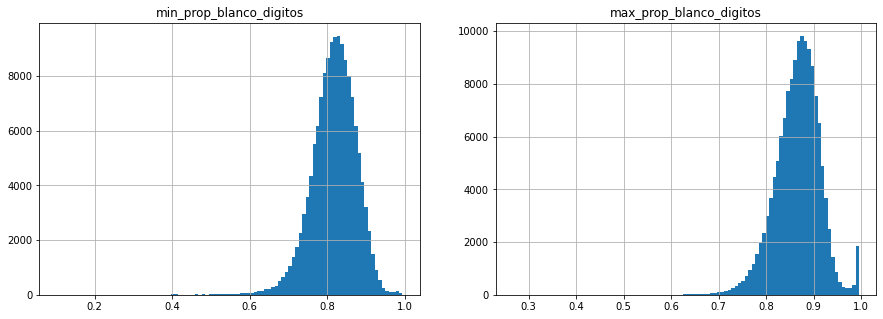

In [20]:
plot_dos_histogramas(df, 'min_prop_blanco_digitos', 'max_prop_blanco_digitos')

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cant_digitos,144126.0,2.303866,0.875680,0.000000,2.000000,3.000000,3.000000,14.000000
min_size_digitos,143012.0,38.617144,11.239762,7.000000,32.000000,37.000000,43.000000,621.000000
max_size_digitos,143012.0,47.191753,20.532765,13.000000,38.000000,44.000000,50.000000,621.000000
min_prop_blanco_digitos,143012.0,0.816377,0.057959,0.102281,0.782931,0.820007,0.855432,0.993352
max_prop_blanco_digitos,143012.0,0.865434,0.048055,0.267430,0.837609,0.869112,0.896400,0.995205


Me hacen ruido los valores 0.99 en la proporcion de digitos blancos.

In [22]:
UMBRAL_PROP_BLANCO_MAXIMO = 0.95

In [23]:
df.query(f"max_prop_blanco_digitos > {UMBRAL_PROP_BLANCO_MAXIMO}").describe().T

,count,mean,std,min,25%,50%,75%,max
cant_digitos,3672.0,2.942810,1.131504,1.000000,2.000000,3.000000,4.000000,9.000000
min_size_digitos,3672.0,49.382081,36.208697,18.000000,33.000000,39.000000,47.000000,621.000000
max_size_digitos,3672.0,138.277778,59.491472,34.000000,72.000000,145.000000,198.000000,621.000000
min_prop_blanco_digitos,3672.0,0.842836,0.077658,0.204837,0.793943,0.838758,0.888686,0.993352
max_prop_blanco_digitos,3672.0,0.979381,0.014980,0.950002,0.965537,0.988123,0.991638,0.995205


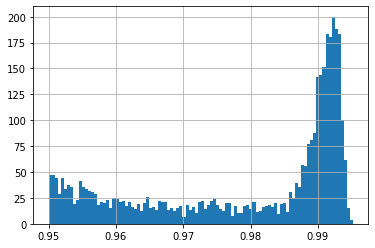

In [24]:
df.query(f"max_prop_blanco_digitos > {UMBRAL_PROP_BLANCO_MAXIMO}").max_prop_blanco_digitos.hist(bins=100)
plt.show()

In [25]:
def plot_digitos(df: pd.DataFrame, idxs: Iterable[int]) -> None:
    for idx in idxs:
        registro = df.loc[idx]
        print(f"===============Index: {idx}===============")
        print(f"Archivo: {registro.id_telegrama}")
        print(f"Partido: {registro.partido}")
        print(f"Tipo: {registro.tipo}")
        print("\n")
        for digito in registro.digitos:
            print(f"Proporcion blanco: {proporcion_pixeles_blancos(digito)}")
            imgshow(digito)

===============Index: 197===============
Archivo: 2100100011X
Partido: frente de todos
Tipo: diputados


Proporcion blanco: 0.7746760295813827


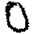

Proporcion blanco: 0.9917008122817182


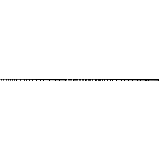

Proporcion blanco: 0.879360929557008


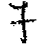

Proporcion blanco: 0.8525583373845406


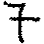

===============Index: 199===============
Archivo: 2100100012X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.9907487333458435


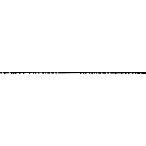

Proporcion blanco: 0.8519539995929167


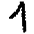

Proporcion blanco: 0.675890356142457


===============Index: 343===============
Archivo: 2100100020X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.9925578736420875


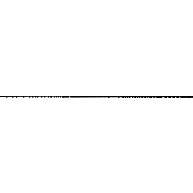

Proporcion blanco: 0.8268467683369645


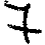

===============Index: 378===============
Archivo: 2100100022X
Partido: unite
Tipo: senadores


Proporcion blanco: 0.9903233293317327


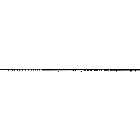

Proporcion blanco: 0.9285471132897604


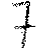

===============Index: 379===============
Archivo: 2100100022X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.9891549579605585


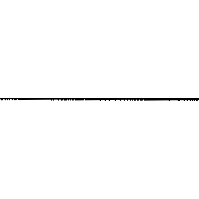

Proporcion blanco: 0.926942061546841


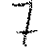

===============Index: 433===============
Archivo: 2100100025X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.7652352401015503


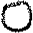

Proporcion blanco: 0.9899076458985961


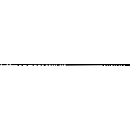

Proporcion blanco: 0.818324860808521


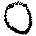

Proporcion blanco: 0.8654679254417816


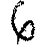

===============Index: 451===============
Archivo: 2100100026X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.9936196882834333


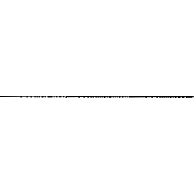

Proporcion blanco: 0.7902511681051193


Proporcion blanco: 0.7233321731059288


Proporcion blanco: 0.8358888707837706


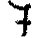

===============Index: 453===============
Archivo: 2100100026X
Partido: frente amplio progresista
Tipo: diputados


Proporcion blanco: 0.7859198041016223


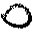

Proporcion blanco: 0.991364200000988


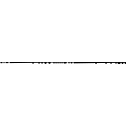

Proporcion blanco: 0.7430743046326735


Proporcion blanco: 0.8478504825447348


===============Index: 505===============
Archivo: 2100100029X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.993146736738179


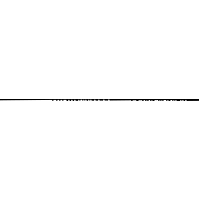

Proporcion blanco: 0.6447088476222247


Proporcion blanco: 0.6017003921568628


Proporcion blanco: 0.7593507625272331


===============Index: 507===============
Archivo: 2100100029X
Partido: frente amplio progresista
Tipo: diputados


Proporcion blanco: 0.9925032592264703


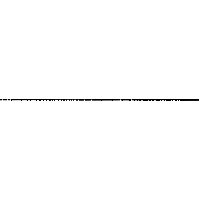

Proporcion blanco: 0.6529956427015251


Proporcion blanco: 0.8514855942376951


Proporcion blanco: 0.764410746997761


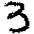

In [26]:
idxs_blanco_sospechoso = df.query(f"max_prop_blanco_digitos > {UMBRAL_PROP_BLANCO_MAXIMO}").head(10).index.values

plot_digitos(df, idxs_blanco_sospechoso)

Parece que en varios casos estamos leyendo la linea divisoria como digito, vamos a eliminar aquellos digitos cuyo porcentaje de blanco sea mayor o igual a 0.95.

In [27]:
df['digitos'] = df.digitos.apply(
    lambda digitos: [digito for digito in digitos if proporcion_pixeles_blancos(digito) < UMBRAL_PROP_BLANCO_MAXIMO]
)

df = calcular_indicadores_digitos(df)

===============Index: 197===============
Archivo: 2100100011X
Partido: frente de todos
Tipo: diputados


Proporcion blanco: 0.7746760295813827


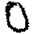

Proporcion blanco: 0.879360929557008


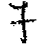

Proporcion blanco: 0.8525583373845406


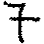

===============Index: 199===============
Archivo: 2100100012X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.8519539995929167


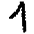

Proporcion blanco: 0.675890356142457


===============Index: 343===============
Archivo: 2100100020X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.8268467683369645


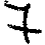

===============Index: 378===============
Archivo: 2100100022X
Partido: unite
Tipo: senadores


Proporcion blanco: 0.9285471132897604


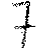

===============Index: 379===============
Archivo: 2100100022X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.926942061546841


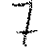

===============Index: 433===============
Archivo: 2100100025X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.7652352401015503


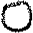

Proporcion blanco: 0.818324860808521


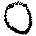

Proporcion blanco: 0.8654679254417816


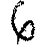

===============Index: 451===============
Archivo: 2100100026X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.7902511681051193


Proporcion blanco: 0.7233321731059288


Proporcion blanco: 0.8358888707837706


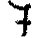

===============Index: 453===============
Archivo: 2100100026X
Partido: frente amplio progresista
Tipo: diputados


Proporcion blanco: 0.7859198041016223


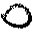

Proporcion blanco: 0.7430743046326735


Proporcion blanco: 0.8478504825447348


===============Index: 505===============
Archivo: 2100100029X
Partido: unite
Tipo: diputados


Proporcion blanco: 0.6447088476222247


Proporcion blanco: 0.6017003921568628


Proporcion blanco: 0.7593507625272331


===============Index: 507===============
Archivo: 2100100029X
Partido: frente amplio progresista
Tipo: diputados


Proporcion blanco: 0.6529956427015251


Proporcion blanco: 0.8514855942376951


Proporcion blanco: 0.764410746997761


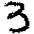

In [29]:
plot_digitos(df, idxs_blanco_sospechoso)

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cant_digitos,144126.0,2.277112,0.871925,0.000000,2.000000,3.000000,3.000000,14.000000
min_size_digitos,142529.0,38.346168,9.606046,7.000000,32.000000,37.000000,43.000000,621.000000
max_size_digitos,142529.0,44.798399,10.741423,13.000000,38.000000,43.000000,49.000000,621.000000
min_prop_blanco_digitos,142529.0,0.815857,0.057359,0.102281,0.782794,0.819790,0.855045,0.949951
max_prop_blanco_digitos,142529.0,0.862541,0.044920,0.267430,0.836710,0.867855,0.894313,0.949997


Ahora vamos a ver los valores chicos de la proporcion de blancos.

In [31]:
UMBRAL_PROP_BLANCO_MINIMO = 0.5

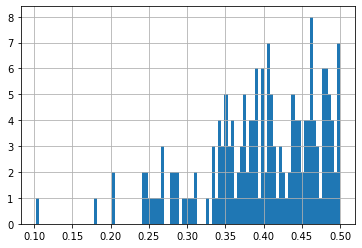

In [32]:
df.query(f"min_prop_blanco_digitos < {UMBRAL_PROP_BLANCO_MINIMO}").min_prop_blanco_digitos.hist(bins=100)
plt.show()

===============Index: 363===============
Archivo: 2100100021X
Partido: frente amplio progresista
Tipo: diputados


Proporcion blanco: 0.7988888888888889


Proporcion blanco: 0.9094229364499635


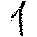

Proporcion blanco: 0.4097959183673469


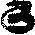

===============Index: 1186===============
Archivo: 2100100067X
Partido: frente de todos
Tipo: senadores


Proporcion blanco: 0.4008102414519527


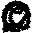

Proporcion blanco: 0.4851920542160945


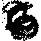

Proporcion blanco: 0.6735813383750965


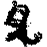

===============Index: 1187===============
Archivo: 2100100067X
Partido: frente de todos
Tipo: diputados


Proporcion blanco: 0.3671654152937575


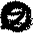

Proporcion blanco: 0.4763197586726998


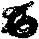

Proporcion blanco: 0.6848829854522455


===============Index: 4292===============
Archivo: 2100200246X
Partido: primero santa fe
Tipo: senadores


Proporcion blanco: 0.4759252813551456


Proporcion blanco: 0.10228091236494598


Proporcion blanco: 0.4110980392156863


Proporcion blanco: 0.21752450980392157


Proporcion blanco: 0.4391356542617047


Proporcion blanco: 0.32292917166866747


Proporcion blanco: 0.5140819964349376


Proporcion blanco: 0.2954781912765106


===============Index: 4298===============
Archivo: 2100200246X
Partido: soberania popular
Tipo: senadores


Proporcion blanco: 0.7343947496353913


Proporcion blanco: 0.36562575647542966


Proporcion blanco: 0.6356158088235294


Proporcion blanco: 0.7193960132529466


Proporcion blanco: 0.538925629423367


Proporcion blanco: 0.720645266416816


Proporcion blanco: 0.6843951985226223


Proporcion blanco: 0.41658823529411765


Proporcion blanco: 0.25


Proporcion blanco: 0.25


In [33]:
idxs_blanco_sospechoso = df.query(f"min_prop_blanco_digitos < {UMBRAL_PROP_BLANCO_MINIMO}").head().index.values

plot_digitos(df, idxs_blanco_sospechoso)

A diferencia con el `max_prop_blanco_digitos` aca no podemos filtrar el digito solamente, ya que por lo visto todo el voto posee verdura.

In [34]:
df = df.query(f"min_prop_blanco_digitos >= {UMBRAL_PROP_BLANCO_MINIMO}").copy()

Ahora vamos a ver el size de los digitos.

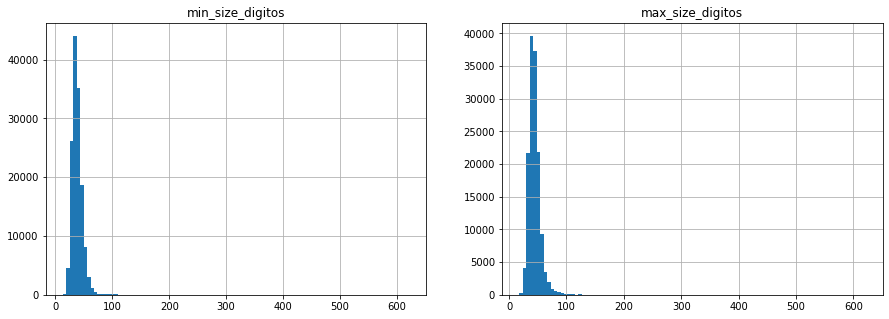

In [35]:
plot_dos_histogramas(df, 'min_size_digitos', 'max_size_digitos')

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cant_digitos,142349.0,2.302039,0.841053,1.000000,2.000000,3.000000,3.000000,8.000000
min_size_digitos,142349.0,38.349388,9.608119,13.000000,32.000000,37.000000,43.000000,621.000000
max_size_digitos,142349.0,44.791119,10.725948,18.000000,38.000000,43.000000,49.000000,621.000000
min_prop_blanco_digitos,142349.0,0.816386,0.055369,0.500020,0.782955,0.819876,0.855083,0.949951
max_prop_blanco_digitos,142349.0,0.862843,0.043699,0.501469,0.836812,0.867917,0.894351,0.949997


In [37]:
UMBRAL_SIZE_MAXIMO = np.mean(df.max_size_digitos) + 4 * np.std(df.max_size_digitos)
UMBRAL_SIZE_MAXIMO

87.69476129001237

In [38]:
df.query(f"max_size_digitos > {UMBRAL_SIZE_MAXIMO}").describe().T

,count,mean,std,min,25%,50%,75%,max
cant_digitos,1126.0,1.683837,0.862784,1.000000,1.000000,2.000000,2.000000,8.000000
min_size_digitos,1126.0,75.341030,37.360526,22.000000,46.000000,62.000000,101.000000,621.000000
max_size_digitos,1126.0,103.652753,23.207877,88.000000,92.000000,97.000000,109.000000,621.000000
min_prop_blanco_digitos,1126.0,0.874347,0.061433,0.577621,0.842884,0.891543,0.919668,0.949951
max_prop_blanco_digitos,1126.0,0.916414,0.025210,0.747708,0.906445,0.920682,0.933624,0.949951


===============Index: 780===============
Archivo: 2100100044X
Partido: juntos
Tipo: senadores


Proporcion blanco: 0.9113263080765699


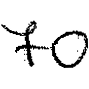

===============Index: 2686===============
Archivo: 2100200153X
Partido: fit
Tipo: senadores


Proporcion blanco: 0.9047882674864373


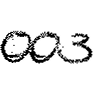

===============Index: 2687===============
Archivo: 2100200153X
Partido: fit
Tipo: diputados


Proporcion blanco: 0.9018365179678739


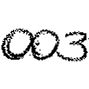

===============Index: 2688===============
Archivo: 2100200153X
Partido: juntos
Tipo: senadores


Proporcion blanco: 0.9069670636849781


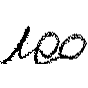

===============Index: 3003===============
Archivo: 2100200173X
Partido: soberania popular
Tipo: diputados


Proporcion blanco: 0.9420549469787916


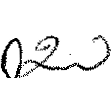

===============Index: 4284===============
Archivo: 2100200246X
Partido: unite
Tipo: senadores


Proporcion blanco: 0.9033421786492375


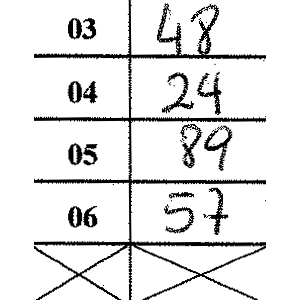

===============Index: 4289===============
Archivo: 2100200246X
Partido: fit
Tipo: diputados


Proporcion blanco: 0.9016020640145302


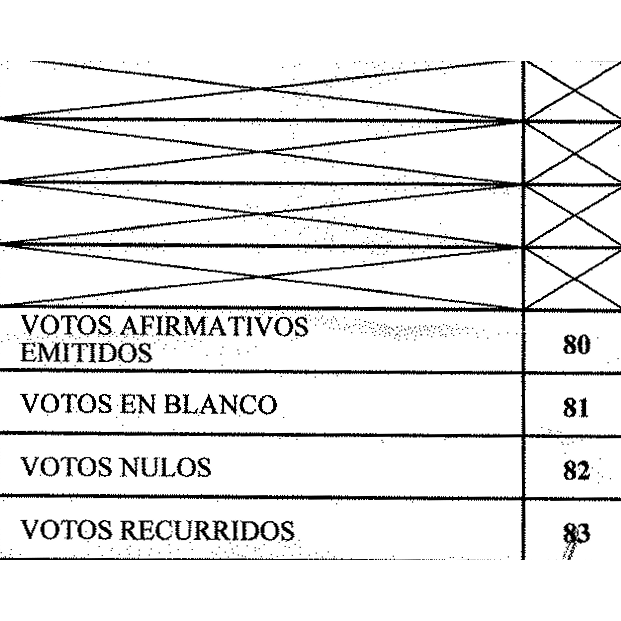

===============Index: 4294===============
Archivo: 2100200246X
Partido: somos futuro
Tipo: senadores


Proporcion blanco: 0.9340880870306535


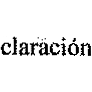

Proporcion blanco: 0.9417573900039964


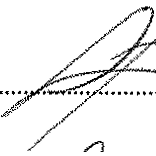

Proporcion blanco: 0.9284587259976582


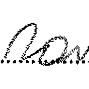

===============Index: 10353===============
Archivo: 2100300588X
Partido: somos futuro
Tipo: diputados


Proporcion blanco: 0.9394257762022409


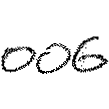

===============Index: 11654===============
Archivo: 2100300660X
Partido: frente de todos
Tipo: senadores


Proporcion blanco: 0.9499509992386036


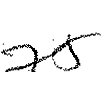

In [39]:
idxs_size_sospechoso = df.query(f"max_size_digitos > {UMBRAL_SIZE_MAXIMO}").head(10).index.values

plot_digitos(df, idxs_size_sospechoso)

Aca parecen haber muchos errores, numeros muy pegados o cosas raras. 

Los eliminamos.

In [40]:
df = df.query(f"max_size_digitos <= {UMBRAL_SIZE_MAXIMO}").copy()

Ahora vamos a ver que pasa con la cantidad de digitos.

In [41]:
df.cant_digitos.value_counts()

3    74745
1    33150
2    32621
4      477
5      149
6       55
7       21
8        5
Name: cant_digitos, dtype: int64

Cada voto deberia tener como maximo 3 digitos. Vamos a ver que pasa con esos que superan los 3 digitos.

In [42]:
df_cant_sospechoso = df.query("cant_digitos > 3").copy()

df_cant_sospechoso.groupby(['id_telegrama']).size()

id_telegrama
2100100007X     1
2100100009X     1
2100100011X     2
2100100042X     1
2100100049X     1
               ..
2102107992X    16
2102208077X     1
2102208097X     1
2102208130X     1
2102208163X     2
Length: 284, dtype: int64

===============Index: 114===============
Archivo: 2100100007X
Partido: juntos
Tipo: senadores


Proporcion blanco: 0.7975056886952312


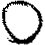

Proporcion blanco: 0.8949312428184885


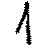

Proporcion blanco: 0.7772363383223112


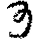

Proporcion blanco: 0.7776955226535058


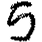

===============Index: 160===============
Archivo: 2100100009X
Partido: frente de todos
Tipo: senadores


Proporcion blanco: 0.9136054421768708


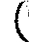

Proporcion blanco: 0.9027450980392157


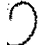

Proporcion blanco: 0.8161237064270153


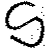

Proporcion blanco: 0.896644154389894


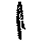

===============Index: 186===============
Archivo: 2100100011X
Partido: juntos
Tipo: senadores


Proporcion blanco: 0.8939137847955817


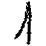

Proporcion blanco: 0.886594637855142


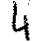

Proporcion blanco: 0.8755438112745098


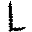

Proporcion blanco: 0.9272929723538956


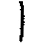

===============Index: 187===============
Archivo: 2100100011X
Partido: juntos
Tipo: diputados


Proporcion blanco: 0.9107509077705156


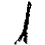

Proporcion blanco: 0.8663540609581132


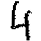

Proporcion blanco: 0.8578736383442266


Proporcion blanco: 0.9160882081364402


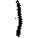

===============Index: 749===============
Archivo: 2100100042X
Partido: somos futuro
Tipo: diputados


Proporcion blanco: 0.8903381796201444


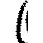

Proporcion blanco: 0.8648576678294677


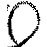

Proporcion blanco: 0.8073428131583211


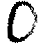

Proporcion blanco: 0.8493886443466275


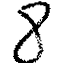

===============Index: 872===============
Archivo: 2100100049X
Partido: primero santa fe
Tipo: senadores


Proporcion blanco: 0.9258430015604858


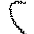

Proporcion blanco: 0.9426713725490196


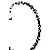

Proporcion blanco: 0.8910974720466699


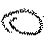

Proporcion blanco: 0.9436810103854237


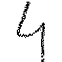

===============Index: 2354===============
Archivo: 2100200134X
Partido: soberania popular
Tipo: senadores


Proporcion blanco: 0.8015315001740341


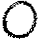

Proporcion blanco: 0.8191179121729817


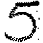

Proporcion blanco: 0.9044630096936734


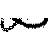

Proporcion blanco: 0.8638985005767013


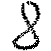

===============Index: 2830===============
Archivo: 2100200162X
Partido: fit
Tipo: senadores


Proporcion blanco: 0.86902599881057


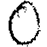

Proporcion blanco: 0.8310734681775406


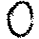

Proporcion blanco: 0.7599466251528967


Proporcion blanco: 0.8495824255628177


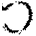

===============Index: 3746===============
Archivo: 2100200215X
Partido: frente amplio progresista
Tipo: senadores


Proporcion blanco: 0.949343487394958


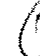

Proporcion blanco: 0.9291038489469862


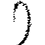

Proporcion blanco: 0.937334247828075


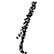

Proporcion blanco: 0.9233149145508381


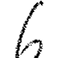

===============Index: 3756===============
Archivo: 2100200215X
Partido: podemos
Tipo: senadores


Proporcion blanco: 0.9341755109640643


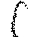

Proporcion blanco: 0.9172655531348342


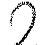

Proporcion blanco: 0.8803373342198272


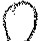

Proporcion blanco: 0.9181082492168465


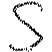

In [43]:
plot_digitos(df, df_cant_sospechoso.head(10).index.values)

La mayoria escribio el numero en letras.

Otros tienen errores de tipeo.

Vamos a eliminarlos.

In [44]:
df = df[~df.id_telegrama.isin(df_cant_sospechoso.id_telegrama.unique())].copy()

Recapitulando, ahora parecen mas normales las 4 variables referidas a los digitos.

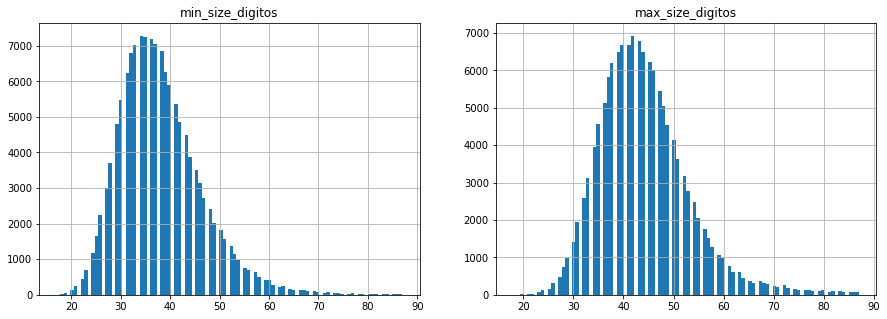

In [45]:
plot_dos_histogramas(df, 'min_size_digitos', 'max_size_digitos')

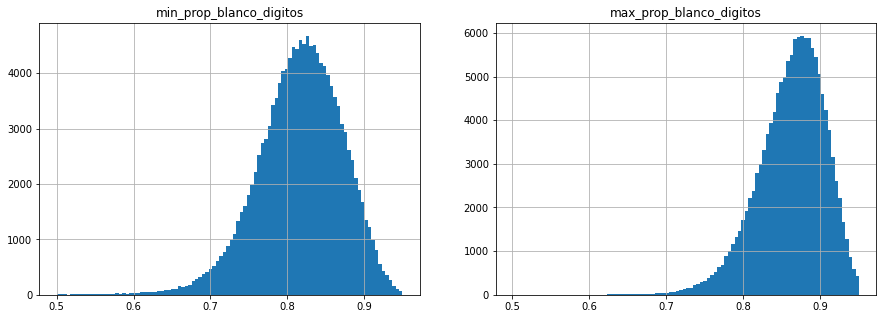

In [46]:
plot_dos_histogramas(df, 'min_prop_blanco_digitos', 'max_prop_blanco_digitos')

In [47]:
id_telegramas_completos = (
    df
    .groupby(['id_telegrama'])
    .partido.count()
    .reset_index()
    .query("partido == 18")
    .id_telegrama
)

df_completos = df[df.id_telegrama.isin(id_telegramas_completos.values)]

In [48]:
df_completos.id_telegrama.unique().shape[0] / 8188

0.810942843185149

A priori, 81% de los telegramas tienen todos los registros leidos.

Sin embargo, tenemos el 97% de los telegramas que leimos "bien" al menos un registro

In [49]:
def escalar_digitos(digitos):
    digitos_ = []
    for digito in digitos:
        digito_escalado = cv2.resize(digito, (28, 28), interpolation=cv2.INTER_AREA)
        digito_escalado = 255 - digito_escalado
        digitos_.append(digito_escalado)
    return np.array(digitos_)

In [50]:
df['digitos_escalados'] = df.digitos.apply(escalar_digitos)

In [51]:
digitos_row = df.digitos_escalados.values
digitos = []

for digito_row in digitos_row:
    for digito in digito_row:
        digitos.append(digito.reshape(len(digito), -1))
    
digitos = np.array(digitos, dtype=object)

In [52]:
digitos

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 6, ..., 0, 0, 0],
        [0, 0, 26, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 6, 0, 0],
        [0, 0, 0, ..., 71, 0, 0],
        [0, 0, 0, ..., 128, 0, 0],
        ...,
        [0, 0, 0, ..., 70, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, 